In [1]:
# PREDICTOR IMPLEMENTADO EN PYTORCH

# Se hará uso de una red neuronal recurrente (LSTM), Long Short Term Memory, por su efectividad para
# el cálculo en problemas de predicción 

In [2]:
# Importamos las librerias requeridas de deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F #Funciones de activacion

# Librerias para la normalización en el preprocesado de datos
from sklearn.preprocessing import MinMaxScaler

# Librerias usadas para el tratamiento de datos y gráficos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Para evitar que el Kernel muera al mostrar imágenes",
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Configuración para el uso de la GPU de 'Cuda'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

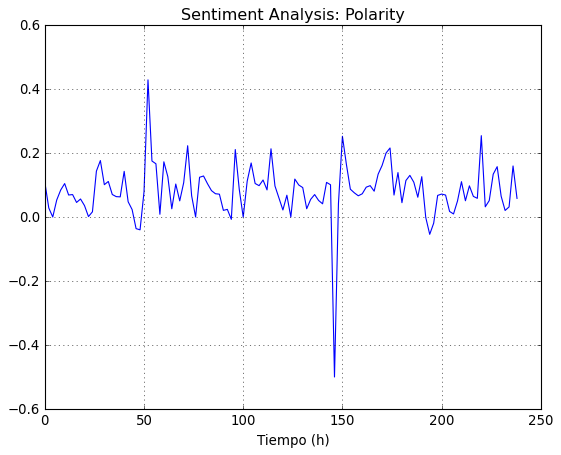

In [3]:
# Configuración de los gráficos
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

# Cargamos nuestro dataset a modo de caja negra, que previamente fue guardado con extension de numpy: .npy
data_v = np.load('Polarity.npy')

# Vector de tiempos. Los datos han sido cogidos en periodos de 2h
horas=np.arange(0,2*len(data_v),2)

# Graficamos los datos
plt.plot(horas,data_v)
plt.xlabel('Tiempo (h)')
plt.title('Sentiment Analysis: Polarity')
plt.grid(True)

# Guardamos la imagen como png, para su posterior estudio
plt.savefig('LSTM_Plots\Polarity_DB.eps')

plt.show()

In [4]:
# Definición del batch de datos de entrada a nuestra red neuronal

def batch_define (input_data, train_window):
    # train_window: Numero de elementos (escalares), dentro del batch
    # input_data: Datos de entrada
    
    batch_input=[] #Batch de salida
    L=len(input_data)
    
    for i in range(L-train_window):
        # Cada Batch estará formado por una tupla de 'train_window' valores, y una etiqueta (siguiente valor)
        train_seq=input_data[i:i+train_window]
        train_label=input_data[i+train_window:i+train_window+1]
       
        batch_input.append((train_seq,train_label))
        
    return batch_input

In [5]:
# Preprocesado de los datos 

# Definimos el numero de datos de entrenamiento (valores escalares). Otra
# forma de verlo es número de valores previos utilizados para la predicción
test_data_size=12

# Definimos nuestro dataset de 'entrenamiento' y 'test'
train_data=data_v[:-test_data_size]
test_data=data_v[-test_data_size:] 

# Guardamos una copia de los datos de test
test_data_copy=test_data

# Normalizamos los datos de 'entrenamiento' unicamente
scaler=MinMaxScaler(feature_range=(-1,1))
train_data_normalized=scaler.fit_transform(train_data.reshape(-1,1))

# Convertimos a tensores nuestro dataset de 'entrenamiento'
train_data_normalized=torch.FloatTensor(train_data_normalized).view(-1)
# El comando view nos indica que lo estamos transformando los datos de entrada a un tensor fila,
# de tantas columnas como datos totales haya en la variable de entrada 'train_data_normalized'

# Definimos el numero de elementos dentro de cada batch y generamos el 'batch' mediante la función
# 'batch_define'
train_window=12
train_batch=batch_define(train_data_normalized, train_window)

# Mostramos por pantalla el batch de datos generados
train_batch[:5]

[(tensor([0.3112, 0.1377, 0.0769, 0.1913, 0.2585, 0.3020, 0.2250, 0.2279, 0.1749,
          0.1981, 0.1537, 0.0798]),
  tensor([0.1118])),
 (tensor([0.1377, 0.0769, 0.1913, 0.2585, 0.3020, 0.2250, 0.2279, 0.1749, 0.1981,
          0.1537, 0.0798, 0.1118]),
  tensor([0.3856])),
 (tensor([0.0769, 0.1913, 0.2585, 0.3020, 0.2250, 0.2279, 0.1749, 0.1981, 0.1537,
          0.0798, 0.1118, 0.3856]),
  tensor([0.4568])),
 (tensor([0.1913, 0.2585, 0.3020, 0.2250, 0.2279, 0.1749, 0.1981, 0.1537, 0.0798,
          0.1118, 0.3856, 0.4568]),
  tensor([0.2945])),
 (tensor([0.2585, 0.3020, 0.2250, 0.2279, 0.1749, 0.1981, 0.1537, 0.0798, 0.1118,
          0.3856, 0.4568, 0.2945]),
  tensor([0.3161]))]

In [6]:
# Definición de la clase para la red neuronal recurrente 'LSTM'

class LSTM(nn.Module):
    def __init__(self, input_size=1,hidden_layer_size=100, output_size=1):
        
        # input_size: Dimension de los datos de entrada
        # hidden_layer_size: Número de neuronas que constará la capa 'LSTM'
        # output_size: Dimensión de los datos de salida (recordar, que estamos haciendo 'forecasting')
        
        # ARQUITECTURA EMPLEADA: 
        # 1º Capa: 1 neurona 'LSTM' con 100 estados ocultos
        # 2º Capa: 1 neurona 'linear'
                                 
        # Heredamos la clase nn.Module
        super(LSTM, self).__init__()
        
        # Definimos los parametros para nuestra DNN
        self.hidden_layer_size=hidden_layer_size
        
        # Generamos la arquitectura de nuestra DNN
        self.lstm=nn.LSTM(input_size, hidden_layer_size)
        
        self.linear=nn.Linear(hidden_layer_size, output_size)
        
        # Ininicializacion del estado oculto inicial
        self.hidden_cell= (torch.zeros(1,1,self.hidden_layer_size), 
                           torch.zeros(1,1,self.hidden_layer_size))
    
    # Definimos la operacion de 'foward'
    def foward(self, input_seq):
        lstm_out, self.hidden_cell=self.lstm(input_seq.view(len(input_seq) ,1 ,-1),self.hidden_cell)
        predictions=self.linear(lstm_out.view(len(input_seq),-1))
        
        return predictions[-1]
    

In [7]:
# Generamos nuestro objeto 'LSTM' y definimos la función de pérdidas así como el optimizador a usar
model=LSTM()
loss_function=nn.MSELoss() # Usamos Mean Error Square como función de costes

# Definicion del optimizador. net.parameters(), le indica los parametros a optimizar, que por defecto
# son todos los parametros posibles, pesos de la regresion lineal, bias...
optimizer=torch.optim.Adam(model.parameters(), lr=0.0001)

EPOCH 0: 0.01677460
EPOCH 5: 0.00186831
EPOCH 10: 0.00176400
EPOCH 15: 0.00169145
EPOCH 20: 0.00163363
EPOCH 25: 0.00158609
EPOCH 30: 0.00154771


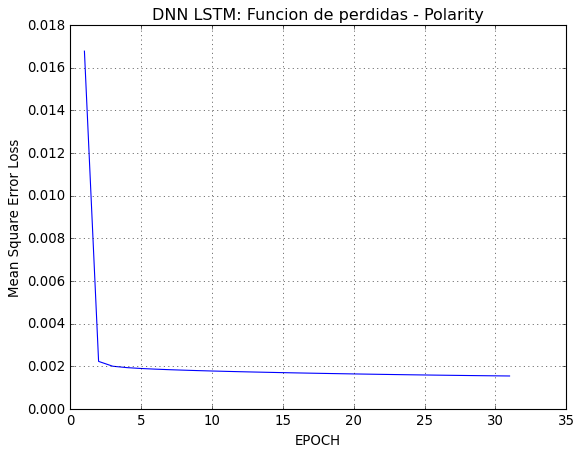

In [8]:
# Entrenamiento de la red neuronal 'LSTM'

# Numero de veces que hacemos la operacion de foward sobre todo nuestro dataset
EPOCHS=31

# Inicializamos el vector que alojará la evolucion de las perdidas en la etapa de entramiento
loss_EPOCH=np.zeros(EPOCHS)

# Definimos el vector con el indice de EPOCH
EPOCH_ind=np.arange(1,EPOCHS+1,1)

for i in range(EPOCHS):
    # En cada EPOCH accedemos al elemento de longitud 'train_window' y su correspondiente "label"
    for seq, labels in train_batch:
        
        # Reseteamos los gradientes a 0 (si no se acumularían los nuevos sobre los de la iteracion anterior)
        optimizer.zero_grad()
        
        # Esta línea de código realmente no se lo que hace!
        model.hidden_cell=(torch.zeros(1,1,model.hidden_layer_size),
                          torch.zeros(1,1, model.hidden_layer_size))
        
        # Realizamos la operación de foward sobre nuestro modelo
        output=model.foward(seq)
        
        # Aplicamos la función de pérdidas sobre para cada salida, y target 'label'
        loss_output=loss_function(output,labels)
        
        # Aplicamos la optimización de descenso por gradiente
        loss_output.backward()
        
        #Ajustamos los pesos de nuestra red neuronal
        optimizer.step()
        
        
    # Mostramos las pérdidas obtenidas por cada 25 EPOCHS
    if (i%5)==0:
        print("EPOCH "+str(i)+": "+'%.8f' %(loss_output)) # Mostramos las pérdidas con 8 decimales
    
    # Guardamos nuestra funcion de perdidas, para estudiar mas tarde la etapa de entrenamiento
    loss_f=loss_output
    loss_EPOCH[i]=loss_f.detach().numpy()
    
# Graficamos el vector de pérdidas
plt.figure()
plt.plot(EPOCH_ind,loss_EPOCH)

plt.grid(True)
plt.title('DNN LSTM: Funcion de perdidas - Polarity')
plt.xlabel('EPOCH')
plt.ylabel('Mean Square Error Loss')

# Guardamos la imagen como png, para su posterior estudio
plt.savefig('LSTM_Plots\Polarity_Loss_F.eps')

plt.show()
    

In [9]:
# Estudio del rendimiento de la red neuronal sobre los datos de test

# Número de muestras a predecir para la etapa de testeo del rendimiento
pred_samples=12

# Los últimos 'train_window' serán usados para predecir la primera muestra. Sobre esta nueva muestra calculada,
# se desplazará la ventana 1 valor y se volverá a calcular la siguiente muestra. El proceso seguiría hasta que se
# alcance el número deseado de muestras predichas

# Generamos el primer grupo de 'window_size' muestras para la predicción del primer valor
test_inputs=train_data_normalized[-train_window:]

# Convertimos a tensores nuestro dataset inicial
train_data_normalized=torch.FloatTensor(test_inputs).view(-1)

# Definimos nuestro vector de numpy 'test_inputs' como lista
test_inputs=train_data[-train_window:].tolist()

for i in range(pred_samples):

    # Realizamos la tarea de 'foward'
    output=model.foward(train_data_normalized)
    
    # Obtenemos la salida de la red neuronal normalizada y la pasamos de tensor a numpy
    output1=output.clone()
    norm_prediction=output1.detach().numpy()
    
    # Denormalizamos el valor calculado
    prediction=scaler.inverse_transform(norm_prediction.reshape(1,-1))
    prediction=np.squeeze(prediction)
    
    # Añadimos el valor calculado sobre la lista de datos anteriormente definida y eliminamos el primer valor,
    # para mantener un tamaño de datos previos a la predicción fijo de tamaño 'window_size'
    test_inputs.append(prediction)
    test_inputs.pop(0)
       
    # Convertimos los valores dentro de la lista a arrays de numpy
    predict_iter=np.asarray(test_inputs)
    predict_iter=np.squeeze(predict_iter)
    
    # Normalizamos nuestro vector de numpy cuyo último valor se corresponde con la predicción actual
    train_data_normalized=scaler.fit_transform(predict_iter.reshape(-1,1))
    
    # Convertimos a tensores nuestro dataset de 'predicción'
    train_data_normalized=torch.FloatTensor(train_data_normalized).view(-1)
    train_data_normalized.requires_grad=True

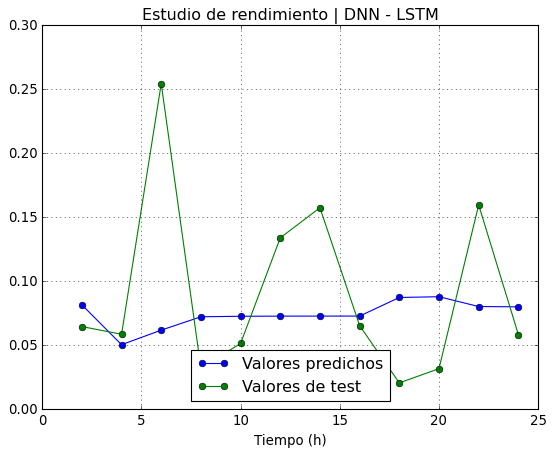

In [10]:
import numpy as np
# Convertimos a vector de numpy la lista con los datos predichos
data_predicted=np.asarray(test_inputs)
data_predicted=np.squeeze(data_predicted)

horas=np.arange(2,26,2)

# Graficamos los datos predichos
plt.figure()
plt.plot(horas,data_predicted,linestyle='-', marker='o')
plt.plot(horas,test_data_copy,linestyle='-', marker='o')

plt.grid(True)
plt.title('Estudio de rendimiento | DNN - LSTM')
plt.xlabel('Tiempo (h)')
plt.legend(['Valores predichos', 'Valores de test'],loc="lower center")

# Guardamos la imagen como png, para su posterior estudio
plt.savefig('LSTM_Plots\Polarity_Testing.eps')

plt.show()

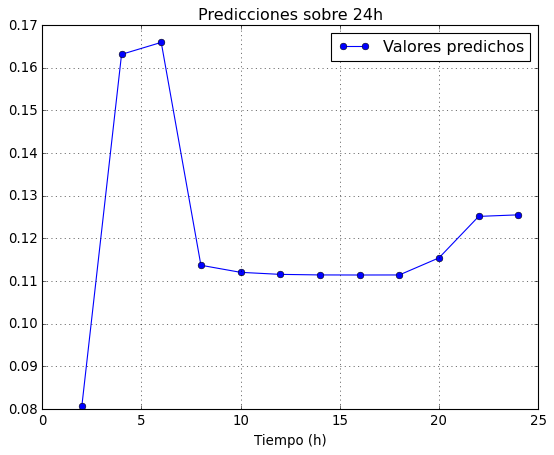

In [11]:
# Preparamos como dataset los ultimos dato obtenidos

# Definimos nuestro dataset de 'entrenamiento' para forecasting de datos futuros
train_data=data_v

# Normalizamos los datos de 'entrenamiento' 
scaler=MinMaxScaler(feature_range=(-1,1))
train_data_normalized=scaler.fit_transform(train_data.reshape(-1,1))

# Convertimos a tensores nuestro dataset de 'entrenamiento'
train_data_normalized=torch.FloatTensor(train_data_normalized).view(-1)
# El comando view nos indica que lo estamos transformando los datos de entrada a un tensor fila,
# de tantas columnas como datos totales haya en la variable de entrada 'train_data_normalized'

# Número de muestras a predecir
pred_samples=12

# Los últimos 'train_window' serán usados para predecir la primera muestra. Sobre esta nueva muestra calculada,
# se desplazará la ventana 1 valor y se volverá a calcular la siguiente muestra. El proceso seguiría hasta que se
# alcance el número deseado de muestras predichas

# Generamos el primer grupo de 'window_size' muestras para la predicción del primer valor
test_inputs=train_data_normalized[-train_window:]

# Convertimos a tensores nuestro dataset inicial
train_data_normalized=torch.FloatTensor(test_inputs).view(-1)

# Definimos nuestro vector de numpy 'test_inputs' como lista
test_inputs=train_data[-train_window:].tolist()

for i in range(pred_samples):

    # Realizamos la tarea de 'foward'
    output=model.foward(train_data_normalized)
    
    # Obtenemos la salida de la red neuronal normalizada y la pasamos de tensor a numpy
    output1=output.clone()
    norm_prediction=output1.detach().numpy()
    
    # Denormalizamos el valor calculado
    prediction=scaler.inverse_transform(norm_prediction.reshape(1,-1))
    prediction=np.squeeze(prediction)
    
    # Añadimos el valor calculado sobre la lista de datos anteriormente definida y eliminamos el primer valor,
    # para mantener un tamaño de datos previos a la predicción fijo de tamaño 'window_size'
    test_inputs.append(prediction)
    test_inputs.pop(0)
       
    # Convertimos los valores dentro de la lista a arrays de numpy
    predict_iter=np.asarray(test_inputs)
    predict_iter=np.squeeze(predict_iter)
    
    # Normalizamos nuestro vector de numpy cuyo último valor se corresponde con la predicción actual
    train_data_normalized=scaler.fit_transform(predict_iter.reshape(-1,1))
    
    # Convertimos a tensores nuestro dataset de 'predicción'
    train_data_normalized=torch.FloatTensor(train_data_normalized).view(-1)


# Convertimos a vector de numpy la lista con los datos predichos
data_predicted=np.asarray(test_inputs)
data_predicted=np.squeeze(data_predicted)

# Vector con las horas predichas a partir del tiempo actual
pred_hours=horas=np.arange(2,26,2)

# Graficamos los datos predichos
plt.figure()

plt.plot(pred_hours,data_predicted,linestyle='-', marker='o')

plt.grid(True)
plt.title('Predicciones sobre 24h')
plt.xlabel('Tiempo (h)')
plt.legend(['Valores predichos', 'Valores de test'])

# Guardamos la imagen como png, para su posterior estudio
plt.savefig('LSTM_Plots\Polarity_Forecast.eps')

plt.show()

In [12]:
# Guardamos los datos obtenidos
np.save("DB_Predicciones/Polarity"+"_"+str(pred_samples)+"_Predicted"+".npy", data_predicted)